In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16 #16
cpus_per_task = 2 #2
omp_num_threads = 2 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

In [4]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00', #memory='120GB',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# GW convergence analysis for AGSLn with n=5

We perform a convergence study for the GW runlevel

## HF Analysis

We do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters as

* RandGVec = 100
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 10x20x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on the EXXRLvcs variable while the VXCRLvcs is left to its DFT value__

__Is this the best choice?__

In [4]:
input_dir = 'DFT_analysis/kpoints_10x20-nbnds_35.save'
run_dir = 'MB_analysis/kpoints_10x20-nbnds_35'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_10x20-nbnds_35/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [6]:
start_band,stop_band = 25,26 # bands range for the computation of the HF corrections
Gamma_index = 1
RandGvec = 100
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
#inp

We perform a convergence run on the EXXRLvcs parameter

In [9]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [10]:
#study.runs[2]

In [16]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
Skip the run of hf-G-exxrlvcs_10.0
Skip the run of hf-G-exxrlvcs_20.0
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-exxrlvcs_30.0Skip the run of
 hf-G-exxrlvcs_40.0
Task [2, 3] ended 
 
Run the task [4] 
Skip the run of hf-G-exxrlvcs_50.0
Task [4] ended 
 


We plot the values of the gap at the $\Gamma$ point

In [17]:
gap_G = [results[r].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results]
gap_G

[2.204822, 2.203676, 2.203482, 2.2035, 2.203482]

Text(0.5, 0, 'EXXRLvcs (Ha)')

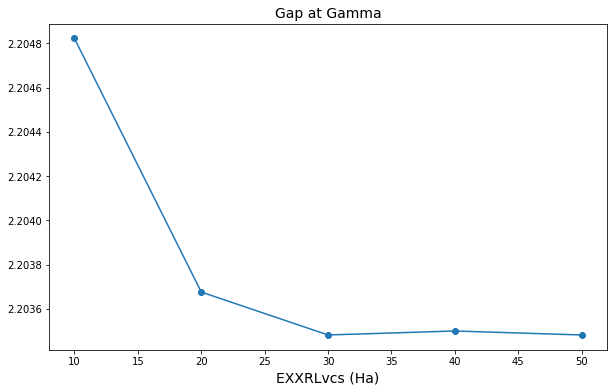

In [18]:
fig, axes = plt.subplots(figsize=(10, 6))
axes.plot(EXXRLvcs,gap_G)
axes.scatter(EXXRLvcs,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('EXXRLvcs (Ha)',size=14)

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 40 Ha

which guarantees the convergence of the HF gap at $\Gamma$ at the level of 1 meV. We ahve also checked that the same
precision is valid for the valence and conduction bands, not only for the gap.

## HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $\Gamma$ in function of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [19]:
start_band,stop_band = 25,26 # bands range for the computation of the HF corrections
Gamma_index = 1
RandGvec = 100
RandQpts = 5e6

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

In [20]:
kvalues = [10,15,20,25,30]

In [21]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    input_dir = 'DFT_analysis/kpoints_%sx%s-nbnds_35.save'%(k,2*k)
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 1 nodes on ismhpc (with 16 mpi and 2 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%sx%s'%(k,2*k)
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 2 parallel tasks
SAVE folder MB_analysis/kpoints_10x20-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_15x30-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_20x40-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_25x50-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_30x60-nbnds_35/SAVE already present. No operations performed.


In [23]:
#study.ids

In [24]:
#study.runs[3]

In [25]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
Skip the run of Skip the run ofhf-G-kpoints_15x30 
hf-G-kpoints_10x20
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-kpoints_20x40
Skip the run of hf-G-kpoints_25x50
Task [2, 3] ended 
 
Run the task [4] 
Skip the run of hf-G-kpoints_30x60
Task [4] ended 
 


In [26]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in results]
gap_G

[2.2034830000000003,
 2.136705,
 2.1199030000000003,
 2.115724,
 2.1150349999999998]

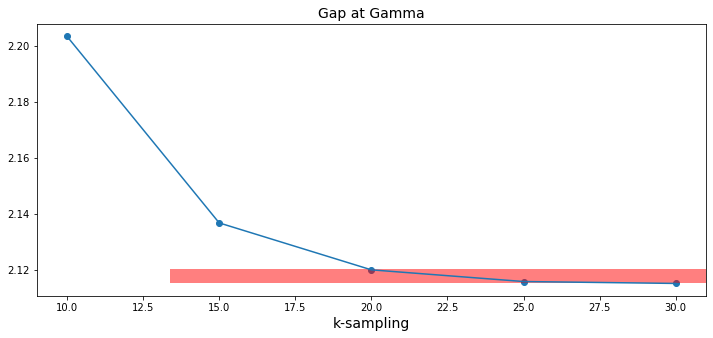

In [35]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(kvalues,gap_G)
axes.scatter(kvalues,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('k-sampling',size=14)
#axes.hlines(gap_G[-1],10.,30,linestyles='-',color='gray',linewidth=1)
#axes.hlines(gap_G[-1]+0.005,10.,30,linestyles='-',color='gray',linewidth=1)
axes.axhspan(gap_G[-1], gap_G[-1]+0.005, xmin = 0.2,facecolor='red', alpha=0.5)

With the 20x40x1 sampling the HF gap at $\Gamma$ is converged at the level of 5 meV.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ using the plasmon pole run level.

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

### Convergence analysis of the screening

#### Convergence of the NGsBlkXp parameter

We use the 10x20x1 k-points sampling (for computational reasons on the ism cluster) and perform a convergence analysis in the BndsRnXp and GbndRnge parameters needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

In [4]:
input_dir = 'DFT_analysis/kpoints_10x20-nbnds_500.save'
run_dir = 'MB_analysis/kpoints_10x20-nbnds_500'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_10x20-nbnds_500/SAVE already present. No operations performed.


We the define the input variables common to all the runs

In [5]:
ntasks_c = 32 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,26
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
#FFTGvecs = 40. # Ha 

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) #,FFTGvecs=FFTGvecs 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 2


First we run over NGsBlkXp and we set the number of bands in the response function to the 300 for a balance between computational time and a proper
check of the convergence of the G size of the response (since these variables are correlated).

The variable LongDrXp is set to the inplane value [1,1,0] 

In [6]:
NGsBlkXp = [4.0,6.0,8.0] #[4.0,6.0,8.0,10.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,300] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_array_variables(LongDrXp=[1.,1.,0.])

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [7]:
#study.runs[2]

In [8]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [2] ended 
 


In [9]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in results]
gap_G

[0.9217709999999999, 0.9299519999999999, 0.931984]

Text(0.5, 0, 'NGsBlkXp (Ha)')

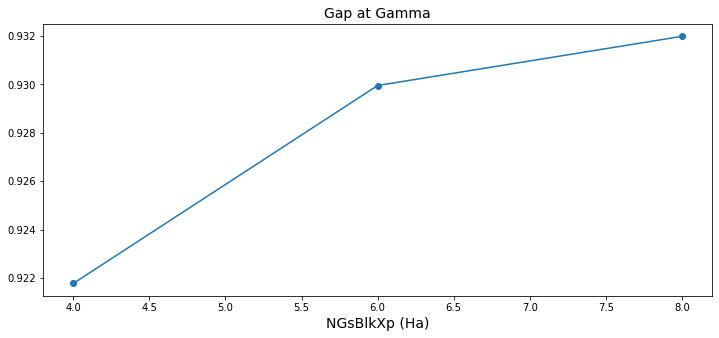

In [10]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(NGsBlkXp,gap_G)
axes.scatter(NGsBlkXp,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('NGsBlkXp (Ha)',size=14)

We observe that the choice NGsBlkXp = 8 Ha could provide convergence of the screening at the level of few meV,
also in view of a possible hidden slower convergence rate due to the correlation between this value and the number of bands.

In case the computational load should be to heavy it is possible to reduce this parameter to NGsBlkXp = 6 Ha. Indeed it worth nothing that 
for this system the direct gap is of the order of the hundreds of eV, so a computational convergence at the level of some tenth of eV
should be acceptable.

#### Convergence of the BndsRnXp parameter

We perform this analysis performing the computations on the Leonardo hpc. 

In [21]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

In [22]:
input_dir = 'DFT_analysis/kpoints_10x20-nbnds_800.save'
run_dir = 'MB_analysis/kpoints_10x20-nbnds_800'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_10x20-nbnds_800/SAVE already present. No operations performed.


We perform a convergence analysis on the number of bands of the screening.For this analysis the
number of bands of the Green function is keep fixed at the value GbndRnge = 300

In [28]:
ntasks_c = 16 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,26
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500]] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands)
    inp.set_array_variables(GbndRnge=GbndRnge)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 

16 1
Initialize a Dataset with 1 parallel tasks


In [34]:
study.ids

['pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300',
 'pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_300',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300']

In [25]:
#study.runs[1]

In [30]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300
Task [2] ended 
 


In [51]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(Bands))]
gap_G

[0.931984, 1.154542, 1.153888]

Text(0.5, 0, 'BndsRnXp')

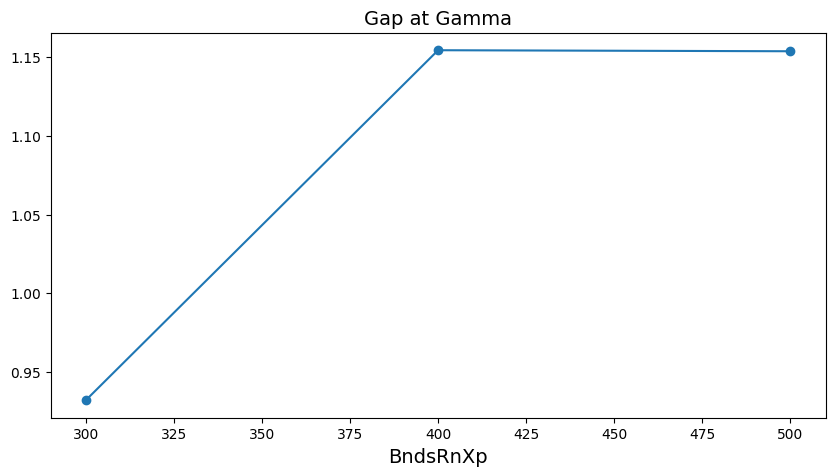

In [52]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(x_vals,gap_G)
axes.scatter(x_vals,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('BndsRnXp',size=14)

We observe that 400 bands in the screening provide an acceptable convergence. We could choos to increase this
value to 500 for safety, since in this procedure we are only checking the convergence rate at $\Gamma$.

#### Convergence of the GbndRnge parameter

We perform this analysis performing the computations on the Leonardo hpc. 

In [53]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

In [54]:
input_dir = 'DFT_analysis/kpoints_10x20-nbnds_800.save'
run_dir = 'MB_analysis/kpoints_10x20-nbnds_800'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_10x20-nbnds_800/SAVE already present. No operations performed.


We perform a convergence analysis on the number of bands of the G function. We also test the effects of the terminator on the G function.

In [91]:
ntasks_c = 16 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,26
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,500]
Bands  = [[1,300],[1,400],[1,500],[1,600],[1,700]] # Bands in the G function

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

inp.set_scalar_variables(GTermKind='BG')

for bands in Bands:
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


16 1
Initialize a Dataset with 2 parallel tasks


In [97]:
study.ids

['pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_400',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_600',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_700',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300-Gterm',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_400-Gterm',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500-Gterm',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_600-Gterm',
 'pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_700-Gterm']

In [98]:
#study.runs[5]

In [103]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run ofSkip the run of  pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_400

Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_600
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300-Gterm
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_700
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500-Gterm
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_400-Gterm
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_600-Gterm
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_700-Gterm
Task [8, 9] ended 
 


In [106]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(Bands))]
gap_G_Gterm = [results[ind+len(Bands)].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(Bands))]

gap_G,gap_G_Gterm

([1.153888,
  1.1519249999999999,
  1.149286,
  1.1480569999999999,
  1.1468059999999998],
 [1.141799, 1.142014, 1.141872, 1.141928, 1.141921])

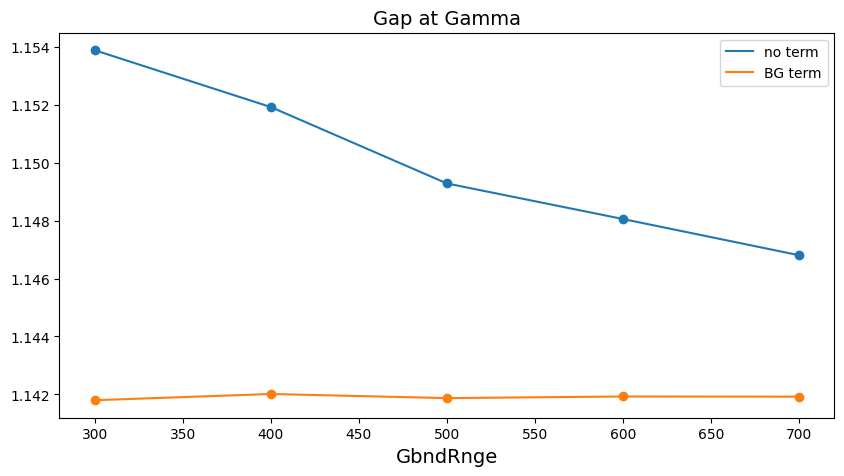

In [112]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(x_vals,gap_G,label='no term')
axes.scatter(x_vals,gap_G)
axes.plot(x_vals,gap_G_Gterm,label='BG term')
axes.scatter(x_vals,gap_G_Gterm)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('GbndRnge',size=14)
axes.legend()

On the basis of this analysis we conclude that the optimal parameters for the convergence of the screening are

NGsBlkXp = 8.0 # Ha G size of the response function
BndsRnXp = [1,500]
GbndRnge = [1,500] with BG terminator

both the bands parameters can be relaxed to the values [1,400] without affecting the convergence of the screening. 

### Convergence analysis of the k-points sampling

We test the effect of the k-points sampling on the GW correction ast the pp level.

In [160]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [187]:
ksamplings = {'10x20': {'folder':'kpoints_10x20-nbnds_800','npoints':66},
             '15x30': {'folder':'kpoints_15x30-nbnds_600','npoints':128},
             '20x40': {'folder':'kpoints_20x40-nbnds_600','npoints':231},
             '25x50': {'folder':'kpoints_25x50-nbnds_600','npoints':338}
            }

In [169]:
for k in ksamplings:
    input_dir=os.path.join('DFT_analysis',ksampligs[k]['folder']+'.save')
    run_dir=os.path.join('MB_analysis',ksampligs[k]['folder'])
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='mpirun -np 2 p2y')

SAVE folder MB_analysis/kpoints_10x20-nbnds_800/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_15x30-nbnds_600/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_20x40-nbnds_600/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_25x50-nbnds_600/SAVE already present. No operations performed.


In [170]:
ntasks_c = 16 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,26
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,400]
GbndRnge  = [1,400] # Bands in the G function

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in ksampligs:
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(GTermKind='BG')
    # append run at G
    #idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
    idd = 'pp-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


16 1
Initialize a Dataset with 4 parallel tasks


In [171]:
study.ids

['pp-G-kpoints_10x20',
 'pp-G-kpoints_15x30',
 'pp-G-kpoints_20x40',
 'pp-G-kpoints_25x50']

In [140]:
#study.runs[2]

In [172]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1, 2, 3]] 

Run the task [0, 1, 2, 3] 
Skip the run ofSkip the run of  pp-G-kpoints_10x20pp-G-kpoints_15x30

Skip the run of pp-G-kpoints_25x50
Skip the run of pp-G-kpoints_20x40
Task [0, 1, 2, 3] ended 
 


In [174]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in range(len(ksamplings.keys()))]
gap_G

[1.1415469999999999, 1.04211, 0.994708, 0.969077]

In [175]:
x_vals = [ksamplings[k]['npoints'] for k in ksamplings]
x_vals

[66, 128, 231, 338]

Text(0.5, 0, 'number of kpoints')

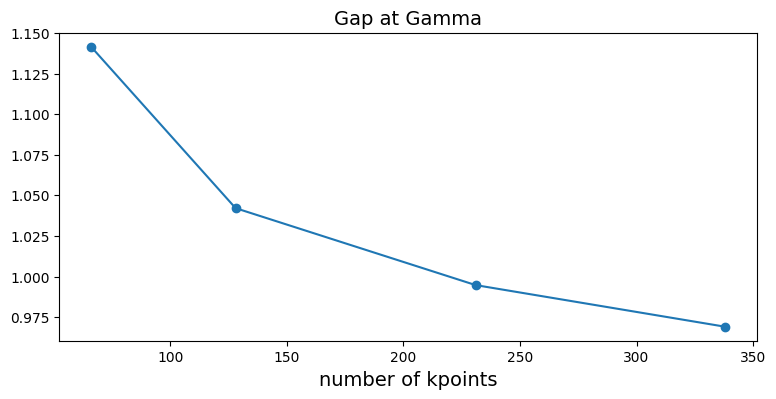

In [176]:
fig, axes = plt.subplots(figsize=(9, 4))
axes.plot(x_vals,gap_G)
axes.scatter(x_vals,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('number of kpoints',size=14)

Computation with improved parameters to check convergence 

In [177]:
ntasks_c = 16 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,26
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,600]
GbndRnge  = [1,400] # Bands in the G function

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

run_dir=os.path.join('MB_analysis',ksamplings['20x40']['folder'])
inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(GTermKind='BG')
# append run at G
idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
#idd = 'pp-G-kpoints_%s'%k
inp.set_kRange(Gamma_index,Gamma_index)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


16 1
Initialize a Dataset with 1 parallel tasks


In [182]:
study.ids

['pp-G-ngsblkxp_8.0-bndsrnxp_600-gbndrnge_400-Gterm']

In [183]:
#study.runs[0]

In [184]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_600-gbndrnge_400-Gterm
Task [0] ended 
 


In [188]:
gap_G_k20x40_imp = results[0].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False)
gap_G_k20x40_imp

0.994043

Text(0.5, 0, 'number of kpoints')

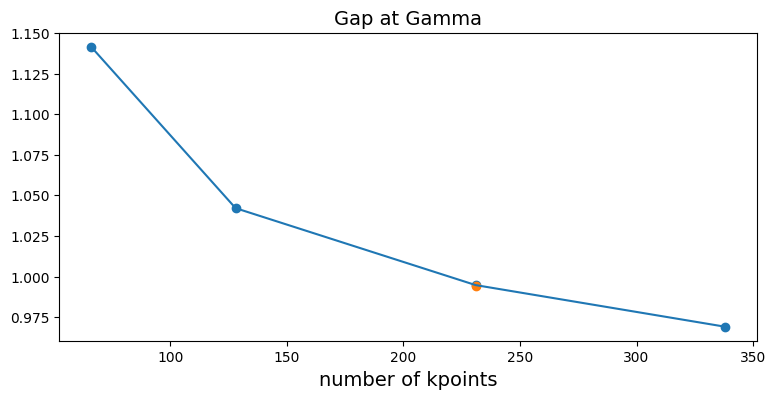

In [189]:
fig, axes = plt.subplots(figsize=(9, 4))
axes.plot(x_vals,gap_G)
axes.scatter(x_vals,gap_G)
axes.scatter(ksamplings['20x40']['npoints'],gap_G_k20x40_imp)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('number of kpoints',size=14)

We observe that the for the chosen values of NGsBlkXp = 6.0 and BndsRnXp = [1,400] the screening is converged.

The best estimate of the gap at $\Gamma$ with the actual k-points sampling is of 969 meV.
This value can be improved by increasing the numbers of k-points, the actual error can be estimated in the order of 10 meV.



### Quasi-particle band structure

We use the convergence test performed above to computed the GW correction in the whole BZ. In this way we can compute the quasi-particle correction of the band structure.


In [15]:
# RunRules for leonardo
nodes = 8
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [3]:
ksamplings = {'10x20': {'folder':'kpoints_10x20-nbnds_800','npoints':66},
             '15x30': {'folder':'kpoints_15x30-nbnds_600','npoints':128},
             '20x40': {'folder':'kpoints_20x40-nbnds_600','npoints':231},
             '25x50': {'folder':'kpoints_25x50-nbnds_600','npoints':338}
            }

In [17]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 24,27
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

kpoints = '20x40'

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,400]
GbndRnge  = [1,400] # Bands in the G function

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 8 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(GTermKind='BG')
# append run for the QP correction in the whole BZ
idd = 'pp-allBZ-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'ndbs','ndb_pp-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

16 2
Initialize a Dataset with 1 parallel tasks


In [19]:
#study.runs[0]

In [20]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: MB_analysis/kpoints_20x40-nbnds_600/job_pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm.out
delete folder: MB_analysis/kpoints_20x40-nbnds_600/pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm.in -J "pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm,ndbs,ndb_pp-ngsblkxp_6.0-bndsrnxp_400" -C pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm
slurm submit:  cd MB_analysis/kpoints_20x40-nbnds_600 ; sbatch job_pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm.sh
computation pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm is running...
computation pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm ended
Run performed in 16h-36m
Task [0] ended 
 


#### Ypp Analysis

We compute the GW correction along a hygh-simmetry path by interpolating the result of the BZ grid 

In [4]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr,executable='ypp')
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [5]:
ndbQP = 'pp-allBZ-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-Gterm/ndb.QP'

In [8]:
kpoints = '20x40'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
start_band,stop_band = 24,27
bands_step = 50

# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]
high_sym = {'G':G_cryst,'K':K_cryst,'M':M_cryst,'M2':M2_cryst} # useful to label the high-sym point on the path
path = [G_cryst,M2_cryst,K_cryst,M_cryst,G_cryst,K_cryst]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

#inp = I.YamboInput(args='ypp -e s',folder=run_dir,filename='ypp.in')
inp = I.YamboInput(folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=[start_band,stop_band],BANDS_steps=bands_step,BANDS_kpts=path)
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_dft'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [30,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [30,'']
study.append_run(id=idd,input=inp,runner=code) 

idd = 'ypp_bands_gw'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [30,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [30,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 2 parallel tasks


In [9]:
study.ids

['ypp_bands_dft', 'ypp_bands_gw']

In [28]:
#study.runs[1]

In [14]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
Skip the run of ypp_bands_gw
Skip the run of ypp_bands_dft
Task [0, 1] ended 
 


In [15]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

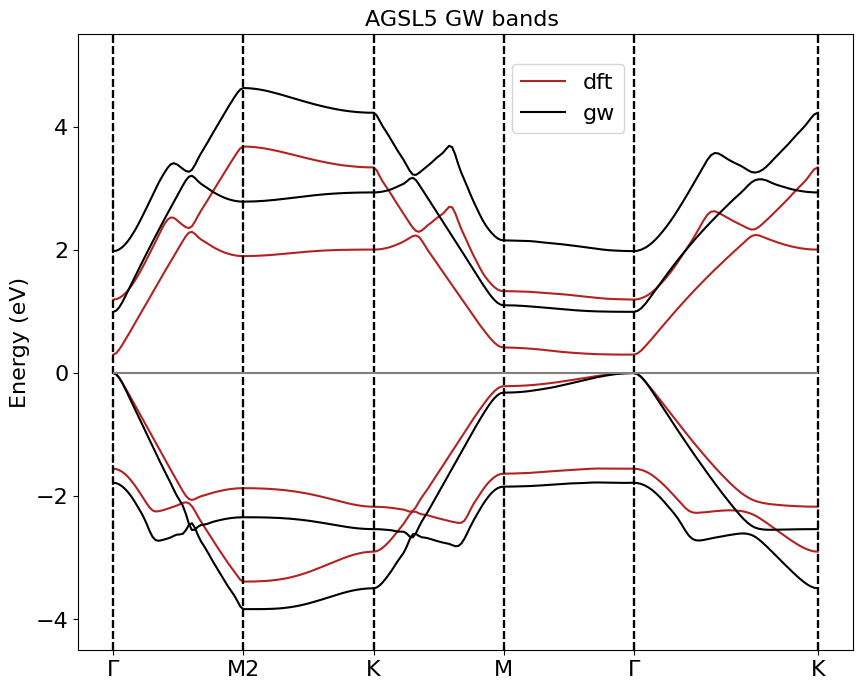

In [38]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='-',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='black')
ax1.hlines(0.,0.,2.707,linestyles='-',color='gray')
ax1.set_ylim(-4.5,5.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('AGSL5 GW bands ',size=16)
ax1.legend(loc=(0.56,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)